In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
W, H = 900, 250

canvas = np.ones((H, W, 3), dtype=np.uint8) * 255

drawing = False
last_x, last_y = None, None

pen_thickness = 18
pen_color = (0, 0, 0)  

In [18]:
def mouse_draw(event, x, y, flags, param):
    global drawing, last_x, last_y, canvas

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        last_x, last_y = x, y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            cv2.line(canvas, (last_x, last_y), (x, y), pen_color, pen_thickness, lineType=cv2.LINE_AA)
            last_x, last_y = x, y

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        last_x, last_y = None, None

In [19]:
cv2.namedWindow("LiveScribe Pad")
cv2.setMouseCallback("LiveScribe Pad", mouse_draw)

print("Controls: draw with mouse | c=clear | s=save | q=quit")

while True:
    cv2.imshow("LiveScribe Pad", canvas)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("q"):
        break
    elif key == ord("c"):
        canvas[:] = 255
    elif key == ord("s"):
        cv2.imwrite("draw.png", canvas)
        print("Saved draw.png")

cv2.destroyAllWindows()


Controls: draw with mouse | c=clear | s=save | q=quit
Saved draw.png


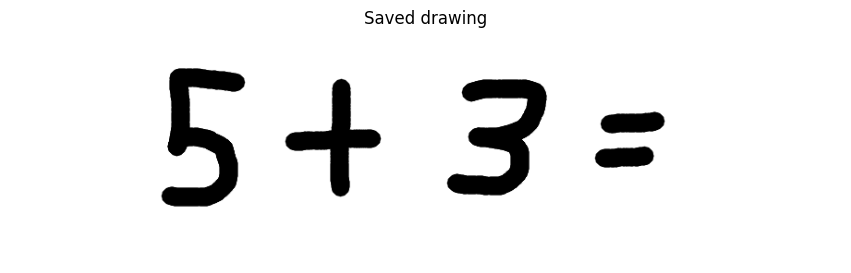

In [20]:
img = cv2.imread("draw.png")
if img is None:
    print("No draw.png found yet. Press 's' in the pad window to save.")
else:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 3))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title("Saved drawing")
    plt.show()


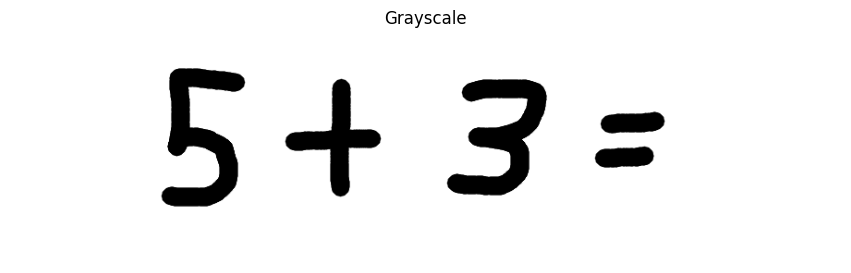

In [21]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 3))
plt.imshow(gray, cmap="gray")
plt.axis("off")
plt.title("Grayscale")
plt.show()


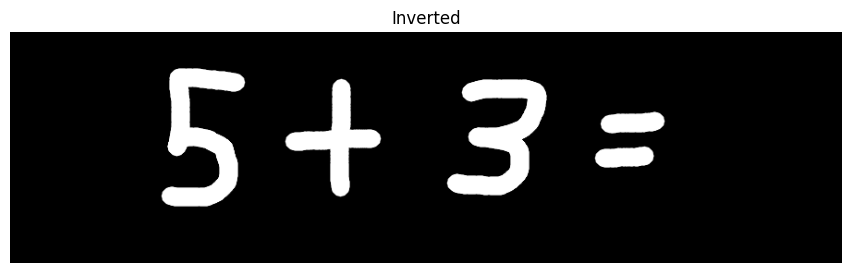

In [22]:
inv = 255 - gray

plt.figure(figsize=(12, 3))
plt.imshow(inv, cmap="gray")
plt.axis("off")
plt.title("Inverted")
plt.show()


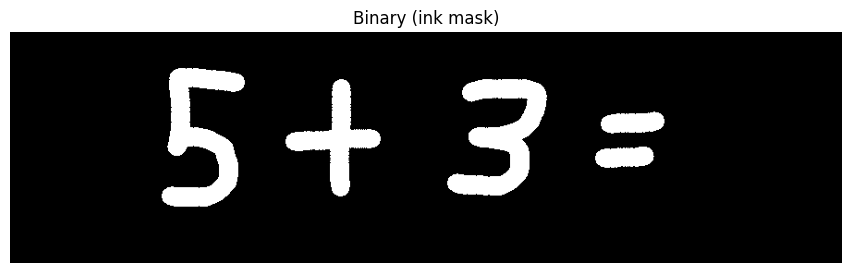

In [23]:
_, binary = cv2.threshold(
    inv, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

plt.figure(figsize=(12, 3))
plt.imshow(binary, cmap="gray")
plt.axis("off")
plt.title("Binary (ink mask)")
plt.show()


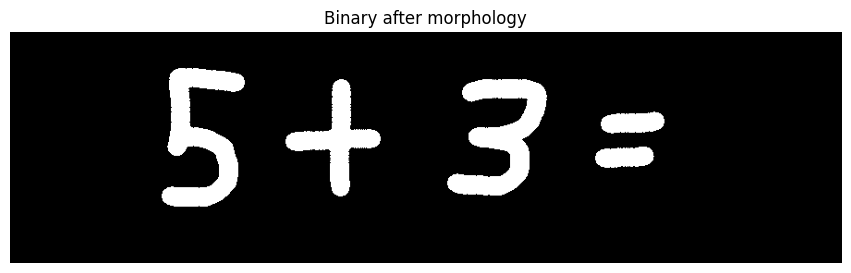

In [24]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
binary_clean = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(12, 3))
plt.imshow(binary_clean, cmap="gray")
plt.axis("off")
plt.title("Binary after morphology")
plt.show()


In [25]:
# Find external contours (each blob)
contours, _ = cv2.findContours(binary_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

boxes = []
min_area = 80  # tune this if you get too much tiny noise

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w * h < min_area:
        continue
    boxes.append((x, y, w, h))

# Sort left-to-right (so expression is in correct order)
boxes = sorted(boxes, key=lambda b: b[0])

boxes


[(164, 39, 90, 150),
 (298, 51, 103, 127),
 (473, 51, 108, 126),
 (633, 124, 64, 23),
 (639, 86, 69, 24)]

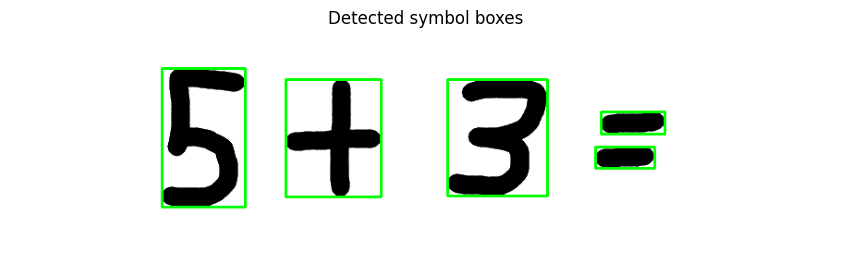

In [26]:
vis = img.copy()

for x, y, w, h in boxes:
    cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)

vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 3))
plt.imshow(vis_rgb)
plt.axis("off")
plt.title("Detected symbol boxes")
plt.show()


In [27]:
crops = []
for x, y, w, h in boxes:
    crop = binary_clean[y:y+h, x:x+w]
    crops.append(crop)

len(crops)


5

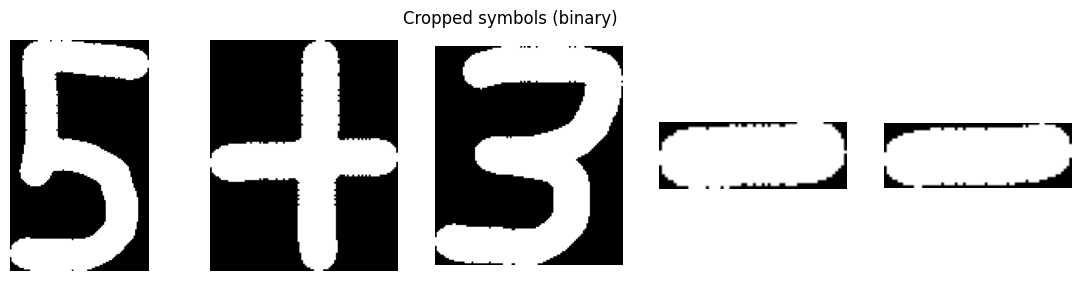

In [28]:
plt.figure(figsize=(14, 3))
n = min(len(crops), 12)

for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(crops[i], cmap="gray")
    plt.axis("off")

plt.suptitle("Cropped symbols (binary)")
plt.show()
